In [2]:
import os
import sys

# Tambahkan path ke root folder project (folder tempat 'utils' berada)
sys.path.append(os.path.abspath('.'))
os.chdir(os.path.abspath('.'))

import random 
import numpy as np
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import os
import sys
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from utils.forward_fn import forward_sequence_classification
from utils.data_utils import DocumentSentimentDataLoader, DocumentSentimentDataset
from utils.metrics import document_sentiment_metrics_fn
from utils.preprocessing_utils import text_cleansing, normalize_slang, slang_dict
torch.cuda.is_available()




True

In [18]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [19]:
# Set random seed
set_seed(26092020)

## Model


In [20]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [22]:
count_param(model)

124443651

## Data Prepration

In [23]:
# from sklearn.model_selection import train_test_split
# import pandas as pd
# dataset = 'datasets/dataset_terakhir.csv'  # Replace with your dataset path
# # Load dataset
# df = pd.read_csv(dataset)

# # Split dataset into train, validation, and test
# train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)  # 70% train, 30% temp
# valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 15% validation, 15% test

# Save split datasets to CSV
train_dataset_path = 'datasets/train.csv'
valid_dataset_path = 'datasets/valid.csv'
test_dataset_path = 'datasets/test.csv'

# train_df.to_csv(train_dataset_path, index=False)
# valid_df.to_csv(valid_dataset_path, index=False)
# test_df.to_csv(test_dataset_path, index=False)


In [24]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=12, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=12, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=12, shuffle=False)

In [7]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'negative': 0, 'neutral': 1, 'positive': 2}
{0: 'negative', 1: 'neutral', 2: 'positive'}


In [26]:
text = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita | Label : neutral (37.752%)


# Fine Tuning


In [27]:
optimizer = optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)
model = model.cuda()


In [28]:
train_losses = []
valid_losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []


n_epochs = 15
patience =10  # Jumlah epoch tanpa perbaikan yang bisa ditoleransi sebelum menghentikan pelatihan
best_valid_loss = float('inf')  # Inisialisasi dengan loss yang sangat tinggi
patience_counter = 0  # Untuk menghitung berapa banyak epoch berturut-turut tanpa perbaikan

for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss += tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        valid_loss = loss.item()
        total_loss += valid_loss

        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    avg_valid_loss = total_loss / len(valid_loader)
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        avg_valid_loss, metrics_to_string(metrics)))
    
    train_losses.append(total_train_loss / len(train_loader))
    valid_losses.append(avg_valid_loss)

    accuracies.append( metrics["ACC"])
    precisions.append(metrics["PRE"])
    recalls.append(metrics["REC"])
    f1_scores.append(metrics["F1"])

    # Early stopping logic
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss  # Update the best valid loss
        patience_counter = 0  # Reset the patience counter
        # Simpan model terbaik
        model.save_pretrained("sentinova_sentiment_model/")
        tokenizer.save_pretrained("sentinova_sentiment_model/")
        print(f"Model saved at epoch {epoch+1} with valid loss: {avg_valid_loss:.4f}")
    else:
        patience_counter += 1  # Increment patience counter
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            model.save_pretrained("sentinova_sentiment_model/")
            tokenizer.save_pretrained("sentinova_sentiment_model/")
            print(f"Model saved at epoch {epoch+1} with valid loss: {avg_valid_loss:.4f}")
            break  # Hentikan pelatihan jika tidak ada perbaikan dalam `patience` epoch berturut-turut


  0%|          | 0/626 [00:50<?, ?it/s]


KeyboardInterrupt: 

Epochs: 12
Train Losses: 12
Valid Losses: 12
Accuracies: 12
Precisions: 12
Recalls: 12
F1 Scores: 12


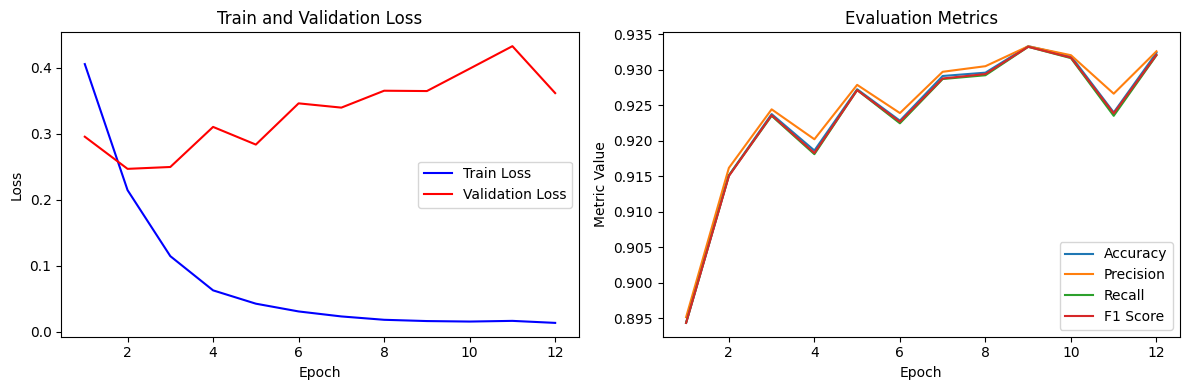

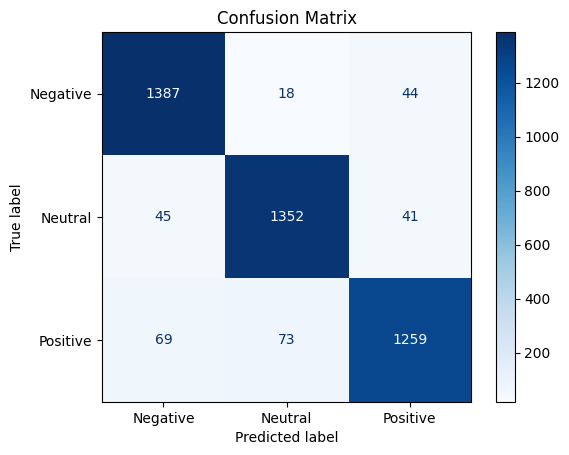

In [ ]:

# Plotting the evaluation metrics after training
epochs = range(1, epoch+2)
print(f"Epochs: {len(epochs)}")
print(f"Train Losses: {len(train_losses)}")
print(f"Valid Losses: {len(valid_losses)}")
print(f"Accuracies: {len(accuracies)}")
print(f"Precisions: {len(precisions)}")
print(f"Recalls: {len(recalls)}")
print(f"F1 Scores: {len(f1_scores)}")

# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses,'b-', label='Train Loss')
plt.plot(epochs, valid_losses,'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Plot Accuracy, Precision, Recall, F1
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label='Accuracy')
plt.plot(epochs, precisions, label='Precision')
plt.plot(epochs, recalls, label='Recall')
plt.plot(epochs, f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Evaluation Metrics')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(list_label, list_hyp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
text = 'produk sampai di luar ekspektasi saya, sangat bagus dan berkualitas'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: produk sampai di luar ekspektasi saya, sangat bagus dan berkualitas | Label : positive (99.983%)


In [ ]:

import torch
import torch.nn.functional as F

# Teks awal
text = 'pengiriman cpt bgt n sesuai'

# Preprocessing: cleansing dan normalisasi slang
clean_text = text_cleansing(text)
normalized_text = normalize_slang(clean_text, slang_dict)

# Tokenisasi dan inferensi
subwords = tokenizer.encode(normalized_text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

# Output dengan probabilitas
print(f'Text: {text} | Normalized: {normalized_text} | Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')


Text: pengiriman cpt bgt n sesuai | Normalized: pengiriman cepat banget dan sesuai | Label: neutral (99.737%)


In [3]:
# Load Tokenizer and Config
reload_tokenizer = BertTokenizer.from_pretrained('sentinova_sentiment_model')
reload_config = BertConfig.from_pretrained('sentinova_sentiment_model')
reload_config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
reload_model = BertForSequenceClassification.from_pretrained('sentinova_sentiment_model', config=reload_config)

In [4]:
train_dataset_path = 'datasets/train.csv'
valid_dataset_path = 'datasets/valid.csv'
test_dataset_path = 'datasets/test.csv'

In [5]:
train_dataset = DocumentSentimentDataset(train_dataset_path, reload_tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, reload_tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, reload_tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=12, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=12, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=12, shuffle=False)

In [8]:
import pandas as pd
from sklearn.metrics import classification_report
from tqdm import tqdm

reload_model.to('cuda')
reload_model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(reload_model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp
    list_label += batch_data[-1].cpu().tolist()  # ground truth labels

# Save prediction
df = pd.DataFrame({'label': list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

# Classification Report
print("Classification Report:")
print(classification_report(list_label, list_hyp))


  0%|          | 0/134 [01:55<?, ?it/s]


AttributeError: 'list' object has no attribute 'cpu'